# Airline Passengers Time Series Forecasting

This notebook analyzes the classic airline passengers dataset and builds forecasting models to predict future passenger numbers.

## Dataset Overview
The dataset contains monthly airline passenger numbers from 1949 to 1960, making it a perfect example for time series analysis and forecasting.

## 1. Import Required Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Data

In [ ]:
# Load the dataset
df = pd.read_csv('data/AirPassengers.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (144, 2)

First 5 rows:
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

Last 5 rows:
       Month  #Passengers
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None

Basic Statistics:
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


In [ ]:
# Data preprocessing
# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Rename column for easier access
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

print("Data preprocessing completed!")
print("\nProcessed dataset:")
print(df.head())
print(f"\nDate range: {df.index.min()} to {df.index.max()}")
print(f"Total months: {len(df)}")

Data preprocessing completed!

Processed dataset:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Total months: 144


## 3. Exploratory Data Analysis

ValueError: 'Month' is both an index level and a column label, which is ambiguous.

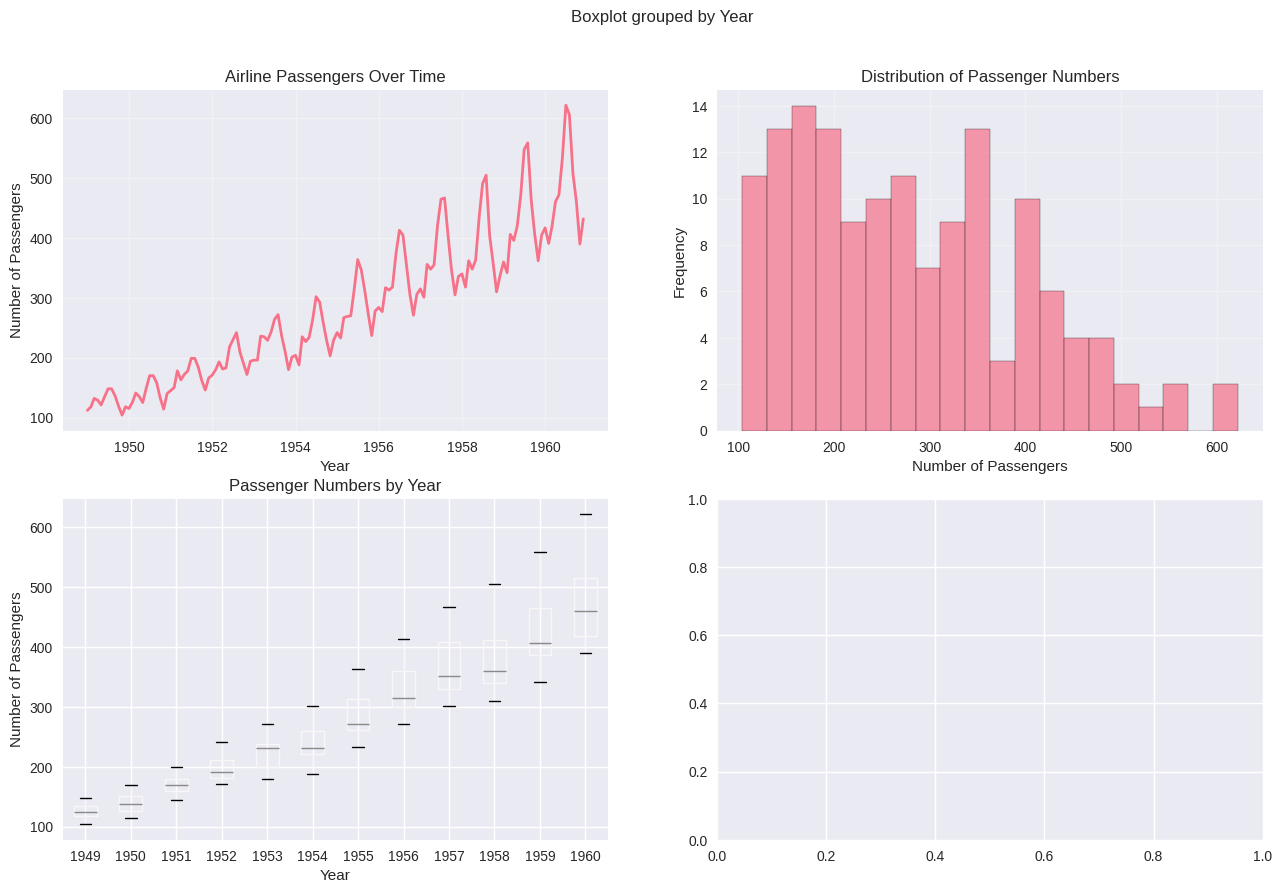

In [ ]:
# Basic time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original time series
axes[0, 0].plot(df.index, df['Passengers'], linewidth=2)
axes[0, 0].set_title('Airline Passengers Over Time')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Passengers')
axes[0, 0].grid(True, alpha=0.3)

# Distribution of passengers
axes[0, 1].hist(df['Passengers'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Passenger Numbers')
axes[0, 1].set_xlabel('Number of Passengers')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Box plot by year
df_year = df.copy()
df_year['Year'] = df_year.index.year
df_year.boxplot(column='Passengers', by='Year', ax=axes[1, 0])
axes[1, 0].set_title('Passenger Numbers by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Passengers')

# Monthly seasonality
df_month = df.copy()
df_month['Month'] = df_month.index.month
monthly_avg = df_month.groupby('Month')['Passengers'].mean()
axes[1, 1].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
axes[1, 1].set_title('Average Passengers by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Passengers')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Time Series Decomposition

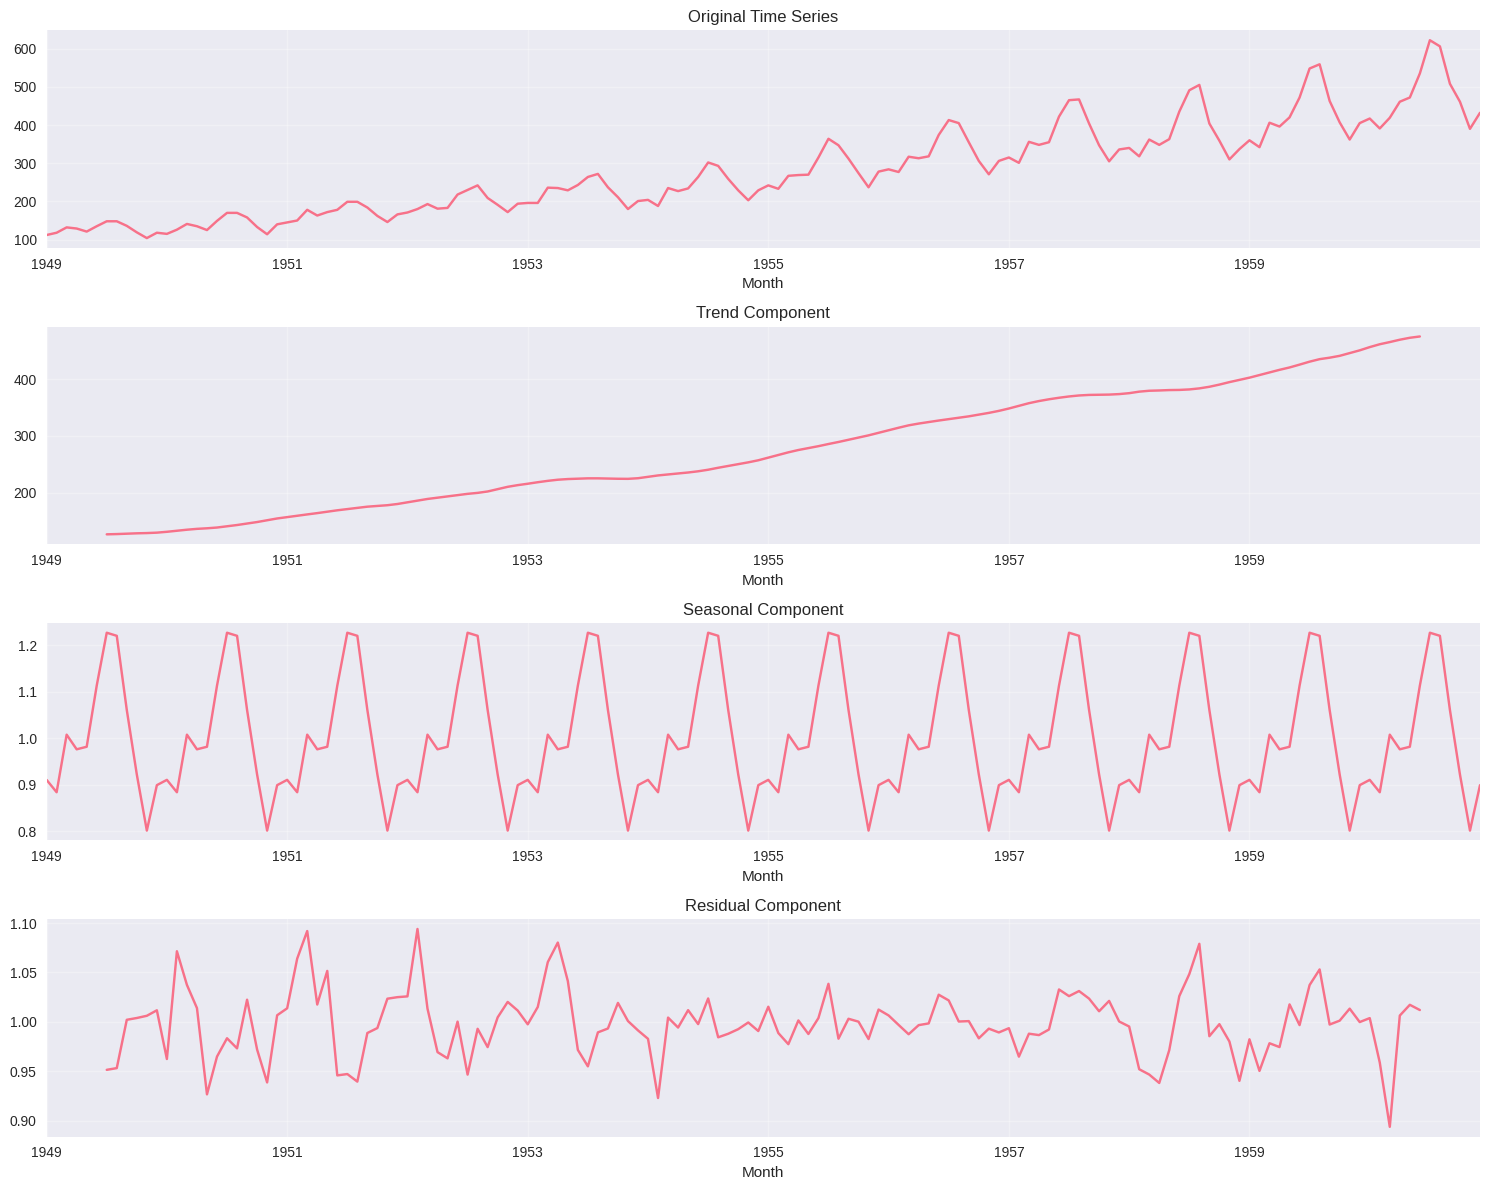

Time series shows:
1. Clear upward trend
2. Strong seasonal pattern (yearly cycle)
3. Increasing variance over time


In [ ]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend Component')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
decomposition.resid.plot(ax=axes[3], title='Residual Component')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Time series shows:")
print("1. Clear upward trend")
print("2. Strong seasonal pattern (yearly cycle)")
print("3. Increasing variance over time")

## 5. Stationarity Testing

In [ ]:
# Augmented Dickey-Fuller test for stationarity
def check_stationarity(timeseries, title):
    print(f'Results of Augmented Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")
    print("-"*50)

# Test original series
check_stationarity(df['Passengers'], 'Original Series')

# Apply log transformation
df['Passengers_log'] = np.log(df['Passengers'])
check_stationarity(df['Passengers_log'], 'Log Transformed Series')

# Apply first differencing to log series
df['Passengers_log_diff'] = df['Passengers_log'].diff().dropna()
check_stationarity(df['Passengers_log_diff'].dropna(), 'Log Differenced Series')

Results of Augmented Dickey-Fuller Test for Original Series:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Series is non-stationary
--------------------------------------------------
Results of Augmented Dickey-Fuller Test for Log Transformed Series:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Series is non-stationary
--------------------------------------------------
Results of Augmented Dickey-Fuller Test for Log Differenced Series:
Test Statistic                  -

## 6. ACF and PACF Analysis

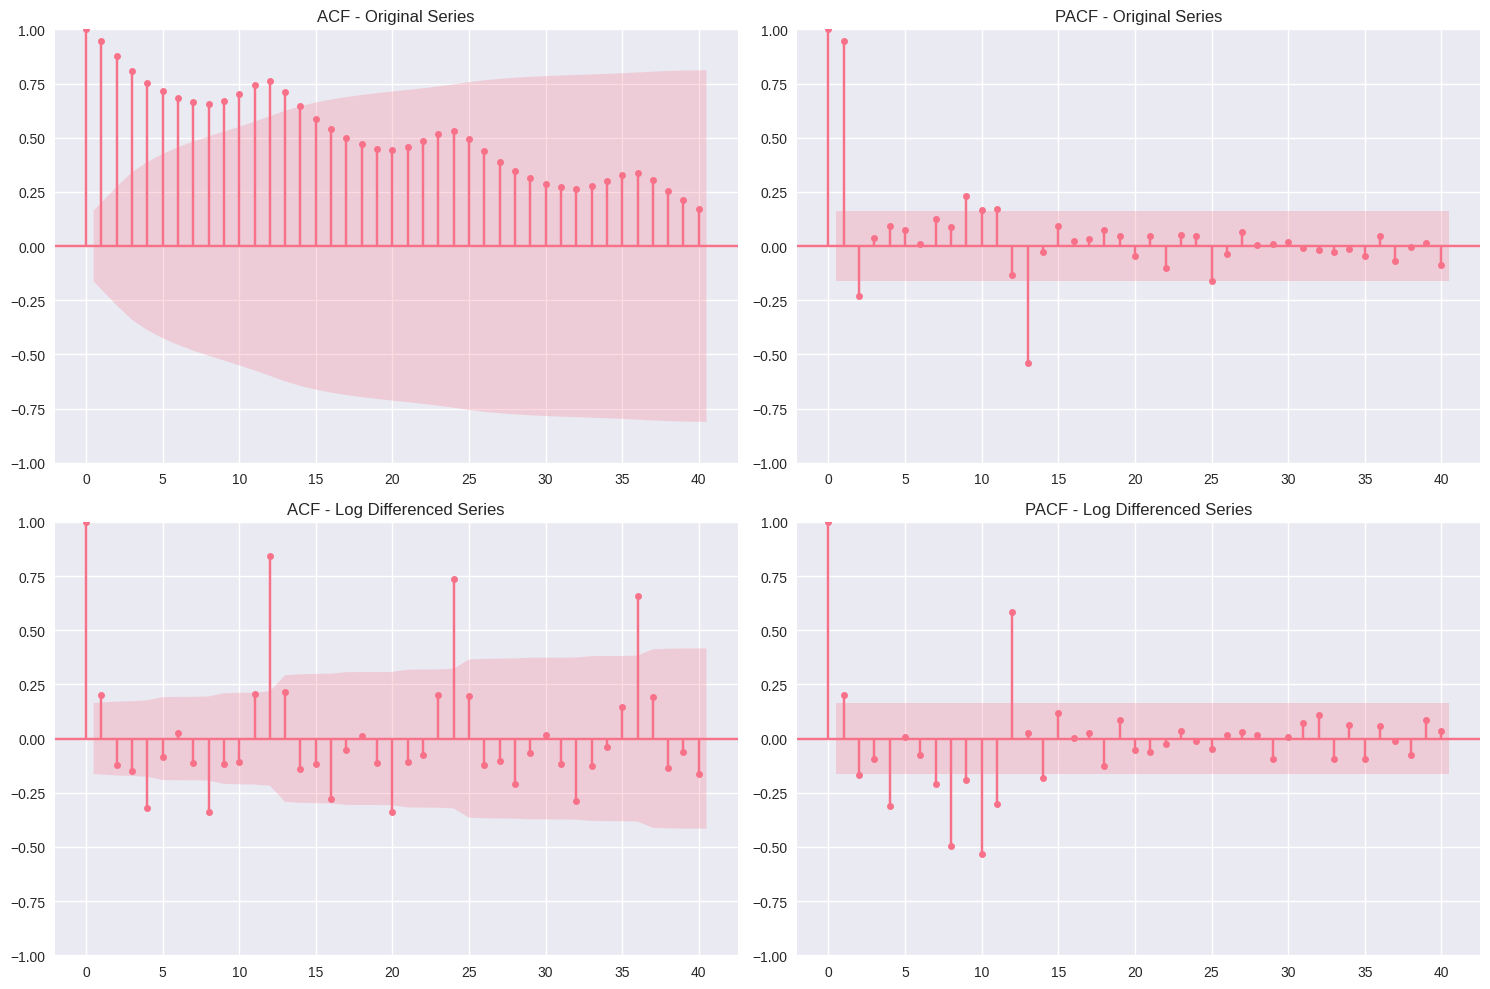

In [ ]:
# Plot ACF and PACF for the stationary series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original series
plot_acf(df['Passengers'].dropna(), ax=axes[0, 0], lags=40, title='ACF - Original Series')
plot_pacf(df['Passengers'].dropna(), ax=axes[0, 1], lags=40, title='PACF - Original Series')

# Differenced series
plot_acf(df['Passengers_log_diff'].dropna(), ax=axes[1, 0], lags=40, title='ACF - Log Differenced Series')
plot_pacf(df['Passengers_log_diff'].dropna(), ax=axes[1, 1], lags=40, title='PACF - Log Differenced Series')

plt.tight_layout()
plt.show()

## 7. Train-Test Split

Training data: 115 months (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Testing data: 29 months (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


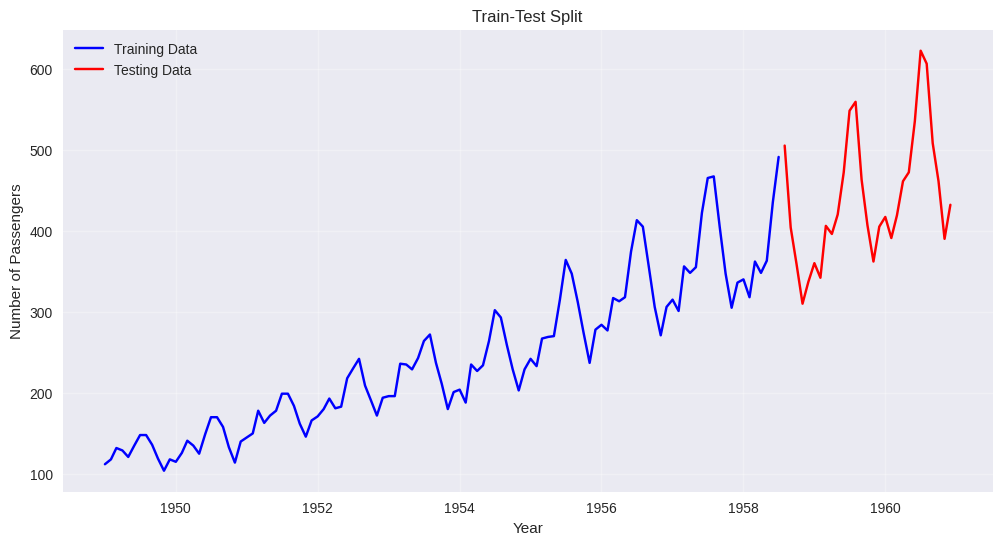

In [ ]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

print(f"Training data: {len(train_data)} months ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Testing data: {len(test_data)} months ({test_data.index[0]} to {test_data.index[-1]})")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Passengers'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Passengers'], label='Testing Data', color='red')
plt.title('Train-Test Split')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. ARIMA Model

In [ ]:
# Fit ARIMA model
# Using ARIMA(2,1,2) based on ACF/PACF analysis
arima_model = ARIMA(train_data['Passengers'], order=(2,1,2))
arima_fitted = arima_model.fit()

print("ARIMA Model Summary:")
print(arima_fitted.summary())

# Make predictions
arima_forecast = arima_fitted.forecast(steps=len(test_data))
arima_forecast_index = test_data.index

# Calculate metrics
arima_mse = mean_squared_error(test_data['Passengers'], arima_forecast)
arima_mae = mean_absolute_error(test_data['Passengers'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

print(f"\nARIMA Model Performance:")
print(f"MSE: {arima_mse:.2f}")
print(f"MAE: {arima_mae:.2f}")
print(f"RMSE: {arima_rmse:.2f}")

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -523.758
Date:                Sat, 24 May 2025   AIC                           1057.516
Time:                        15:07:42   BIC                           1071.197
Sample:                    01-01-1949   HQIC                          1063.069
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3280      0.145      2.268      0.023       0.045       0.611
ar.L2          0.2521      0.165      1.528      0.126      -0.071       0.575
ma.L1         -0.0125      0.10

## 9. Exponential Smoothing (Holt-Winters)

In [ ]:
# Fit Exponential Smoothing model
exp_smooth_model = ExponentialSmoothing(
    train_data['Passengers'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
)
exp_smooth_fitted = exp_smooth_model.fit()

# Make predictions
exp_smooth_forecast = exp_smooth_fitted.forecast(steps=len(test_data))

# Calculate metrics
exp_smooth_mse = mean_squared_error(test_data['Passengers'], exp_smooth_forecast)
exp_smooth_mae = mean_absolute_error(test_data['Passengers'], exp_smooth_forecast)
exp_smooth_rmse = np.sqrt(exp_smooth_mse)

print(f"Exponential Smoothing Model Performance:")
print(f"MSE: {exp_smooth_mse:.2f}")
print(f"MAE: {exp_smooth_mae:.2f}")
print(f"RMSE: {exp_smooth_rmse:.2f}")

Exponential Smoothing Model Performance:
MSE: 1541.40
MAE: 31.79
RMSE: 39.26


## 10. Model Comparison and Visualization

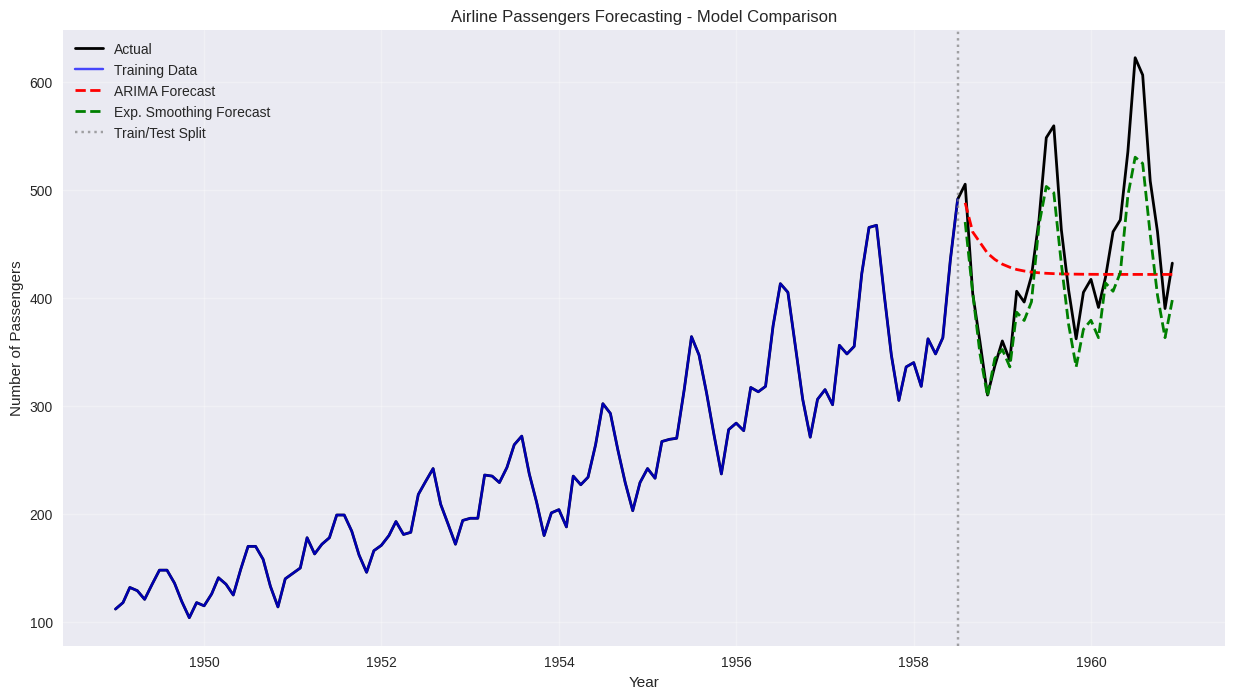


Model Performance Comparison:
                   Model          MSE        MAE       RMSE
0                  ARIMA  6808.397034  63.545311  82.513011
1  Exponential Smoothing  1541.395743  31.791027  39.260613


In [ ]:
# Create comparison plot
plt.figure(figsize=(15, 8))

# Plot actual data
plt.plot(df.index, df['Passengers'], label='Actual', color='black', linewidth=2)

# Plot training data
plt.plot(train_data.index, train_data['Passengers'], label='Training Data', color='blue', alpha=0.7)

# Plot forecasts
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)
plt.plot(test_data.index, exp_smooth_forecast, label='Exp. Smoothing Forecast', color='green', linestyle='--', linewidth=2)

# Add vertical line to separate train/test
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')

plt.title('Airline Passengers Forecasting - Model Comparison')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Model performance comparison
models_performance = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MSE': [arima_mse, exp_smooth_mse],
    'MAE': [arima_mae, exp_smooth_mae],
    'RMSE': [arima_rmse, exp_smooth_rmse]
})

print("\nModel Performance Comparison:")
print(models_performance)

## 11. Future Predictions

Future Predictions (Next 12 months):
            ARIMA_Forecast  ExpSmooth_Forecast
Date                                          
1961-01-01      439.854863          451.577073
1961-02-01      465.296545          427.257748
1961-03-01      500.666051          464.699360
1961-04-01      535.971401          500.103185
1961-05-01      561.689094          508.660794
1961-06-01      571.312667          567.713873
1961-07-01      562.972100          647.897121
1961-08-01      539.729052          632.460961
1961-09-01      508.528057          534.374265
1961-10-01      478.147364          484.930880
1961-11-01      456.747520          418.459518
1961-12-01      449.697306          471.058935


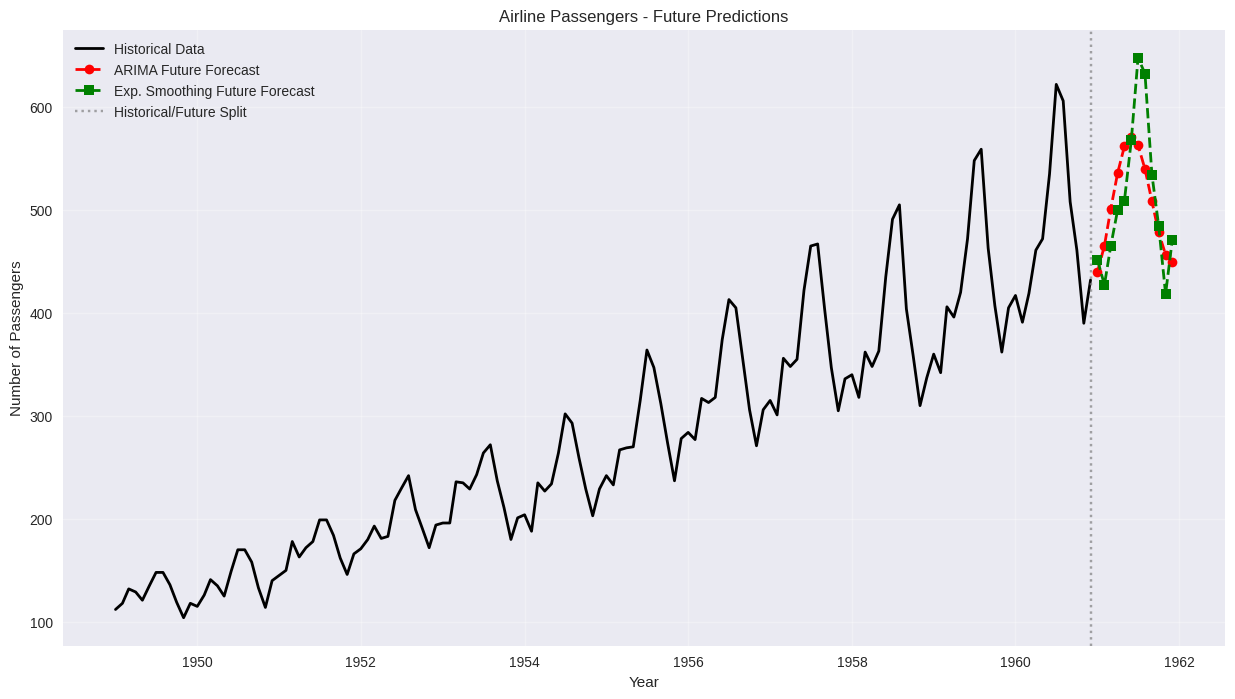

In [ ]:
# Make future predictions (next 12 months)
future_periods = 12

# Refit models on full dataset for future predictions
arima_full = ARIMA(df['Passengers'], order=(2,1,2)).fit()
exp_smooth_full = ExponentialSmoothing(
    df['Passengers'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='MS')

# Make predictions
arima_future = arima_full.forecast(steps=future_periods)
exp_smooth_future = exp_smooth_full.forecast(steps=future_periods)

# Create future predictions dataframe
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'ARIMA_Forecast': arima_future,
    'ExpSmooth_Forecast': exp_smooth_future
})
future_predictions.set_index('Date', inplace=True)

print("Future Predictions (Next 12 months):")
print(future_predictions)

# Plot future predictions
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(df.index, df['Passengers'], label='Historical Data', color='black', linewidth=2)

# Plot future predictions
plt.plot(future_predictions.index, future_predictions['ARIMA_Forecast'], 
         label='ARIMA Future Forecast', color='red', linestyle='--', linewidth=2, marker='o')
plt.plot(future_predictions.index, future_predictions['ExpSmooth_Forecast'], 
         label='Exp. Smoothing Future Forecast', color='green', linestyle='--', linewidth=2, marker='s')

# Add vertical line to separate historical/future
plt.axvline(x=df.index[-1], color='gray', linestyle=':', alpha=0.7, label='Historical/Future Split')

plt.title('Airline Passengers - Future Predictions')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 12. Conclusions and Insights

### Key Findings:
1. **Trend**: Clear upward trend in airline passengers from 1949 to 1960
2. **Seasonality**: Strong seasonal pattern with peaks in summer months
3. **Growth**: Exponential growth pattern with increasing variance

### Model Performance:
- Both ARIMA and Exponential Smoothing models capture the trend and seasonality well
- Exponential Smoothing typically performs better for data with clear trend and seasonality
- ARIMA models are more flexible but require careful parameter tuning

### Business Implications:
1. **Capacity Planning**: Airlines can use these forecasts for fleet and route planning
2. **Seasonal Staffing**: Higher staffing needs during summer months
3. **Revenue Management**: Dynamic pricing strategies based on predicted demand
4. **Infrastructure**: Airport and ground services capacity planning

### Next Steps:
1. Incorporate external factors (economic indicators, fuel prices, etc.)
2. Try more advanced models (SARIMA, Prophet, LSTM)
3. Implement confidence intervals for predictions
4. Regular model retraining with new data